
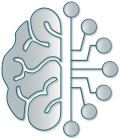

In [ ]:
# This now triggers vID.init() automatically via __init__.py
import pyphyschemtools as t4pPC
from pyphyschemtools import fg, hl, bg, color
t4pPC.init()
%matplotlib inline

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


__author__ = "Romuald Poteau, LPCNO (INSA-CNRS-UT lab, Toulouse, France)"

# Recurrent neural networks (RNN)

## Introduction

<div class="intro">

Time Series is a collection of data points indexed based on the time they were collected. Most often, the data is recorded at regular time intervals. 

Forecasting future Time Series values is a quite common problem in practice. Predicting the weather for the next week, the euros / dollars exchange rate tomorrow, or even a future heart failure are common examples.

Time Series data introduces a “hard dependency” on previous time steps, so the assumption that independence of observations doesn’t hold. 
</div>


## General overview

<div class="intro">

The general architecure of an RNN and some variants is:
<img width="450" src="./DS4B-Slides/pngs/ZooNN/RNNfamily.png" style="display:block; margin-left:auto; margin-right:auto;" id="RNN"/> 

Let's continue with our "*top-down approach*", which consists in learning how to implement an algorithm before going back and covering the theory. An RNN is characterized by **direction of the flow of information between its layers**. As traditional NN, they utilize training data to learn. They are distinguished by their “memory” as they take information from prior inputs to influence the current input and output. While **traditional deep NN** assume that **inputs and outputs are independent of each other**, the output of recurrent neural networks depend on the prior elements within the sequence. Their ability to use internal state (memory) makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition, or any problem which exhibits temporal dynamic behavior, such as **molecular dynamics**.

Let's consider the trajectory of a ball in a 3D space. What we want at any time $t$ is to predict its new position at $t +\delta t$. Let's call the coordinates at time $t$:

$$[x_1(t), x_2(t), x_3(t)]$$

and 

$$[\hat{x}_1(t +\delta t), \hat{x}_2(t +\delta t), \hat{x}_3(t +\delta t)]$$

the predicted ones at $t +\delta t$. In terms of "traditional" NN, we want:

<img width="10%" src="./ML-Figures/RNN_usualNN.svg" style="display:block; margin-left:auto; margin-right:auto;" id="RNNtradNN"/>

that can be summarized as:

<img width="10%" src="./ML-Figures/RNN_usualNNsimp.svg" style="display:block; margin-left:auto; margin-right:auto;" id="RNNtradNNsimp"/>

<br>

But what can't be done with a traditional NN is to take into account several instants of the ball’s motion, whereas RNNs can. **Recurrent** means the output at the *current* time step becomes the input to the *next* time step, but with information of the *previous* time step. In contrast with a classical neuron, a recurrent neuron can be schematized as:

<img width="650" src="./ML-Figures/Rneuron_vs_Cneuron.svg" style="display:block; margin-left:auto; margin-right:auto;" id="RNvsCN"/>

where the calculation of the output is given by

$y=\sigma\left(W_{x}^{T}X+b\right)$

for the classical neuron, and by

$y_{t}=\sigma\left(W_{x}^{T}X_{t}+w_{y}y_{t-1}+b_{t}\right)$
 
for the recurrent neuron
</div>
<br>
<div class="rqT" title="Warning!">

Don't make a confusion between **back-propagation**, a **feedback mechanism of the training process**, and this **recurrent mechanism**, that occurs during the application of an **already trained RNN**.
    
</div>
<br>
<div class="intro">

RNNs are actually more complicated than this simple scheme. They must be seen as fully recurrent neural networks, which connect the outputs of all neurons to the inputs of all neurons, as illustrated below. What appears to be layers are, in fact, different time steps of the same fully recurrent neural network.

<img width="650" src="./ML-Figures/RNN_unfold.svg" style="display:block; margin-left:auto; margin-right:auto;" id="FRNN"/>
    
</div>

<div class="intro">
    
But the major drawback of an RNN is that it has a short-term memory, like a **goldfish**

<img width="200" src="./ML-Figures/Goldfish2-DallE.png" style="display:block; margin-left:auto; margin-right:auto;" id="goldfish"/>

<br>**Long Short Term Memory**(LSTM) RNNs were proposed to introduce a long-term memory in addition the short-term memory of a standard RNN. LSTM is normally augmented by recurrent gates called "forget gates". LSTM prevents backpropagated errors from vanishing or exploding. LSTM can learn tasks that require memories of events that happened thousands or even millions of discrete time steps earlier. An LSTM unit looks like

<img width="650" src="./ML-Figures/LSTM.svg" style="display:block; margin-left:auto; margin-right:auto;" id="LSTM"/>

<br>**Gated Recurrent Units** (GRUs) are a gating mechanism in recurrent neural networks introduced in 2014. They are used in the full form and several simplified variants. They have fewer parameters than LSTM, as they lack an output gate. A GRU unit can be schematized as

<img width="650" src="./ML-Figures/GRU.svg" style="display:block; margin-left:auto; margin-right:auto;" id="GRU"/>
</div>

## Develop LSTM Models for Time Series Forecasting

### Preparation of sequences

#### With a in-house function

In [59]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
# def split_sequence(sequence, n_steps, n_predict=1, n_batch=1):
#     X, y = [], []
#     batchX, batchy =  [], []
#     for i in range(len(sequence)):
#         # find the end of this pattern
#         end_ix = i + n_steps
#         end_iy = end_ix + n_predict
#         # check if we are beyond the sequence
#         if end_iy > len(sequence):
#             break
#         # gather input and output parts of the pattern
#         seq_X, seq_y = sequence[i:end_ix], sequence[end_ix:end_iy]
#         # print(seq_x,seq_y)
#         if ((i+1) % n_batch == 0):
#             print(i, (i+1) % n_batch, (i+1)//n_batch)
#             batchX.append(seq_X)
#             batchy.append(seq_y)
#             X.append(batchX)
#             y.append(batchy)
#             print(batchX,batchy)
#             batchX, batchy =  [], []
#         else:
#             batchX.append(seq_X)
#             batchy.append(seq_y)
#     if (batchX != []): #last batch, if necessary
#         print(batchX,batchy)
#         X.append(batchX)
#         y.append(batchy)
        
#     return array(X), array(y)

def split_sequence(sequence, n_steps, n_predict=1, n_features=1, printXy=True):
    '''
    splits a univariate sequence into samples
    '''
    X, y = [], []
    batchX, batchy =  [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        end_iy = end_ix + n_predict
        # check if we are beyond the sequence
        if end_iy > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_X, seq_y = sequence[i:end_ix], sequence[end_ix:end_iy]
        X.append(seq_X)
        y.append(seq_y)
    X = array(X)
    y = array(y)
    n_time_val = X.shape[0]
    print(f"Total number of f(t) values = {n_time_val}\n"
          f"Number of time steps per sequence = {n_steps}\n"
          f"Number of features to predict = {n_features}\n")
    if printXy:
        print()
        t4pPC.centertxt('X',weight='bold',size=14)
        print(X)
        t4pPC.centertxt('y',weight='bold',size=14)
        print(y)
    if printXy:
        t4pPC.centertxt('Reshaping of X and y',weight='bold',size=14)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((n_time_val, n_steps, n_features))
    if printXy: 
        print()
        for i in range(len(X)):
            print(X[i],y[i])       
    print(f"Returning X and y arrays with shapes {X.shape} & {y.shape}")
    return array(X), array(y)
        
t4pPC.centertxt('Define input sequence that contains both X and y',weight='bold',size=14)
# define input sequence
raw_sequence = []
n_values = 21
for i in range(n_values):
    raw_sequence.append(i*10)
print(raw_sequence)

# choose a number of time steps and number of time steps to predict
n_steps = 5
n_predict = 1
# define the number of features of the function, i.e. the dimension of the function
n_features = 1
# split into samples
X, y = split_sequence(raw_sequence, n_steps, n_predict)

# summarize the data
for i in range(len(X)):
    print(f"{i}. X = \n{X[i]}. y= {y[i]}")



[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
Total number of f(t) values = 16
Number of time steps per sequence = 5
Number of features to predict = 1




[[  0  10  20  30  40]
 [ 10  20  30  40  50]
 [ 20  30  40  50  60]
 [ 30  40  50  60  70]
 [ 40  50  60  70  80]
 [ 50  60  70  80  90]
 [ 60  70  80  90 100]
 [ 70  80  90 100 110]
 [ 80  90 100 110 120]
 [ 90 100 110 120 130]
 [100 110 120 130 140]
 [110 120 130 140 150]
 [120 130 140 150 160]
 [130 140 150 160 170]
 [140 150 160 170 180]
 [150 160 170 180 190]]


[[ 50]
 [ 60]
 [ 70]
 [ 80]
 [ 90]
 [100]
 [110]
 [120]
 [130]
 [140]
 [150]
 [160]
 [170]
 [180]
 [190]
 [200]]



[[ 0]
 [10]
 [20]
 [30]
 [40]] [50]
[[10]
 [20]
 [30]
 [40]
 [50]] [60]
[[20]
 [30]
 [40]
 [50]
 [60]] [70]
[[30]
 [40]
 [50]
 [60]
 [70]] [80]
[[40]
 [50]
 [60]
 [70]
 [80]] [90]
[[50]
 [60]
 [70]
 [80]
 [90]] [100]
[[ 60]
 [ 70]
 [ 80]
 [ 90]
 [100]] [110]
[[ 70]
 [ 80]
 [ 90]
 [100]
 [110]] [120]
[[ 80]
 [ 90]
 [100]
 [110]
 [120]] [130]
[[ 90]
 [100]
 [110]
 [120]
 [130]] [140]
[[100]
 [110]
 [120]
 [130]
 [140]] [150]
[[110]
 [120]
 [130]
 [140]
 [150]] [160]
[[120]
 [130]
 [140]
 [150]
 [160]] [170]
[[130]
 [140]
 [150]
 [160]
 [170]] [180]
[[140]
 [150]
 [160]
 [170]
 [180]] [190]
[[150]
 [160]
 [170]
 [180]
 [190]] [200]
Returning X and y arrays with shapes (16, 5, 1) & (16, 1)
0. X = 
[[ 0]
 [10]
 [20]
 [30]
 [40]]. y= [50]
1. X = 
[[10]
 [20]
 [30]
 [40]
 [50]]. y= [60]
2. X = 
[[20]
 [30]
 [40]
 [50]
 [60]]. y= [70]
3. X = 
[[30]
 [40]
 [50]
 [60]
 [70]]. y= [80]
4. X = 
[[40]
 [50]
 [60]
 [70]
 [80]]. y= [90]
5. X = 
[[50]
 [60]
 [70]
 [80]
 [90]]. y= [100]
6. X = 
[[ 60]


<div class="rqT" title="reshape?">

Reshaping means changing the shape of an array.

The shape of an array is the number of elements in each dimension. Wanna try it? <a href="./AdvancedPython.ipynb#reshape">Load the "AdvancedPython.ipynb" notebook</a>
</div>

#### With a time series generator

<div class="intro">

`TimeseriesGenerator ` is a utility class for generating batches of temporal data. It is useful to easily handle time series. Let's play a bit with it. Consider a simple univariate time series: f(t) = [0, 1, 2, 3, 4, 5, 6, ....., 20], i.e. a regular augmentation of this property f. `TimeSeriesGenerator` basically embeds the time series inside a `TimeSeriesGenerator` object that will later directly be feed inside the keras/tensorflow network

</div>

In [60]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

print(raw_sequence)
batch_sizeT = 1
sequence_lenT = 5
strideT = 1
generator = TimeseriesGenerator(raw_sequence, raw_sequence, stride=strideT, length=sequence_lenT, batch_size=batch_sizeT)
print(f'Number of batch trains available : {len(generator)}')
for i in range(len(generator)):
    print(f"Batch {i}. {generator[i]}")


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
Number of batch trains available : 16
Batch 0. (array([[ 0, 10, 20, 30, 40]]), array([50]))
Batch 1. (array([[10, 20, 30, 40, 50]]), array([60]))
Batch 2. (array([[20, 30, 40, 50, 60]]), array([70]))
Batch 3. (array([[30, 40, 50, 60, 70]]), array([80]))
Batch 4. (array([[40, 50, 60, 70, 80]]), array([90]))
Batch 5. (array([[50, 60, 70, 80, 90]]), array([100]))
Batch 6. (array([[ 60,  70,  80,  90, 100]]), array([110]))
Batch 7. (array([[ 70,  80,  90, 100, 110]]), array([120]))
Batch 8. (array([[ 80,  90, 100, 110, 120]]), array([130]))
Batch 9. (array([[ 90, 100, 110, 120, 130]]), array([140]))
Batch 10. (array([[100, 110, 120, 130, 140]]), array([150]))
Batch 11. (array([[110, 120, 130, 140, 150]]), array([160]))
Batch 12. (array([[120, 130, 140, 150, 160]]), array([170]))
Batch 13. (array([[130, 140, 150, 160, 170]]), array([180]))
Batch 14. (array([[140, 150, 160, 170, 180]]), array([190]

<div class="intro">

```
tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data,
    targets,
    length,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=128
)
```
    
- `data` and `targets` are basically what the network will use
    -  Numpy 2D array containing consecutive timesteps (axis 0 = time dimension)
    - `targets` corresponding to timesteps in `data`. It should have same length as `data`
- `length` is the length of each sequence used to train our network
- `stride` is the period between each record in your original data
- `batch_size` represents the number of sub-series per batch
</div>
<br>
<div class="rq">

You can play a bit with these values to see the changes
<br>
    
**NB.** The in-house `split_sequence` function is more simple than the `TimeseriesGenerator` of `keras`, since it does not create sequences with batches
</div>

### Prepare the training and test sets

In [61]:
split_value = 0.8
ntrain = int(len(X)*split_value)
X_train = X[:ntrain]
X_test  = X[ntrain:]
y_train = y[:ntrain]
y_test  = y[ntrain:]
print(f"Size of the training set = {ntrain:6}")
print(f"Size of the     test set = {len(X)-ntrain:6}")


Size of the training set =     12
Size of the     test set =      4


### Vanilla LSTM

<div class="intro">

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction. It is also called a one to one RNN.  It is used for general machine learning problems, which has a single input and a single output. It can be summarized as:

<img src="./ML-Figures/One2OneRNN.svg" style="display:block; margin-left:auto; margin-right:auto; width:'15%'" id="O2ORNN"/> 
 
</div>

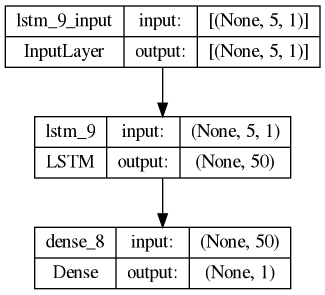

In [62]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
  

# define model
modelV = Sequential()
modelV.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
modelV.add(Dense(n_features)) 
modelV.compile(optimizer='adam',
              loss='mse',
              metrics   = ['mae'] )

from tensorflow.keras.utils import plot_model
plot_model(modelV, show_shapes=True, show_layer_names=True)


In [63]:
# fit model
epochs = 300
historyV = modelV.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_test,y_test))

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 14814.4385 - mae: 114.9081 - val_loss: 43033.6211 - val_mae: 207.0364
Epoch 2/300
1/1 [==============================] - 0s 43ms/step - loss: 14638.8311 - mae: 114.2624 - val_loss: 42390.6289 - val_mae: 205.4882
Epoch 3/300
1/1 [==============================] - 0s 44ms/step - loss: 14472.5010 - mae: 113.6440 - val_loss: 41802.9023 - val_mae: 204.0624
Epoch 4/300
1/1 [==============================] - 0s 42ms/step - loss: 14315.3330 - mae: 113.0513 - val_loss: 41271.9180 - val_mae: 202.7650
Epoch 5/300
1/1 [==============================] - 0s 41ms/step - loss: 14166.3516 - mae: 112.4820 - val_loss: 40788.9414 - val_mae: 201.5770
Epoch 6/300
1/1 [==============================] - 0s 43ms/step - loss: 14023.2217 - mae: 111.9279 - val_loss: 40340.1875 - val_mae: 200.4662
Epoch 7/300
1/1 [==============================] - 0s 44ms/step - loss: 13881.6641 - mae: 111.3737 - val_loss: 39895.7305 - val_mae: 199.3590
Epoch 8/

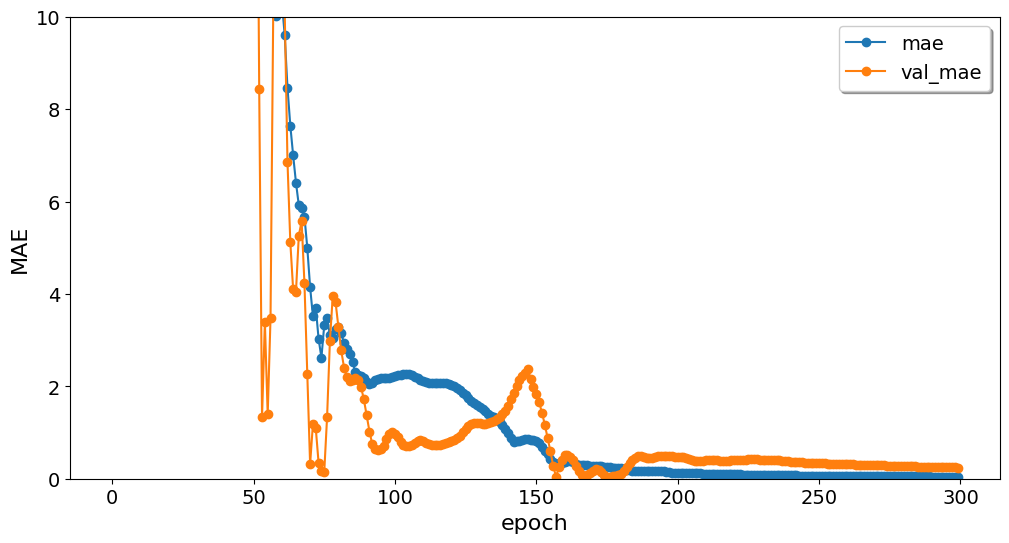

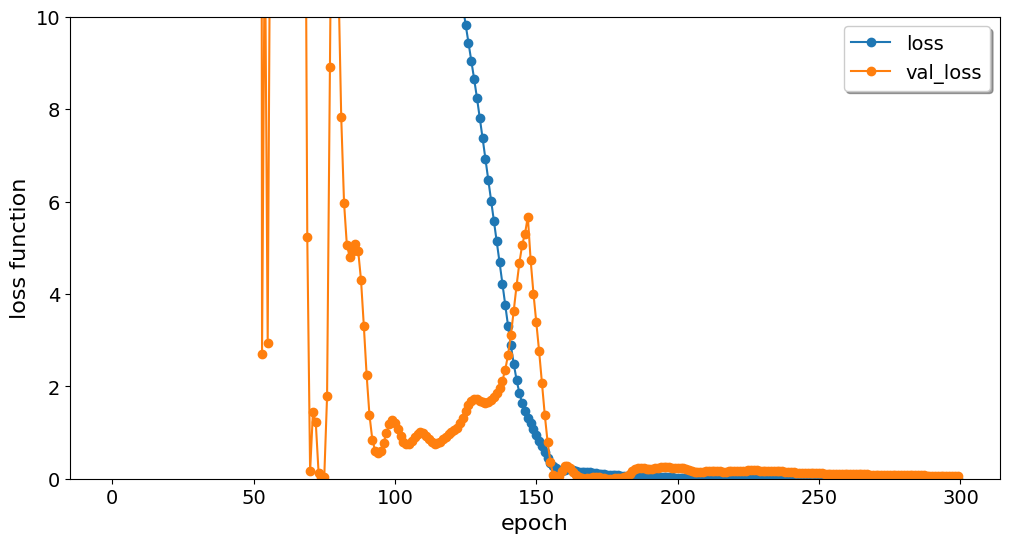

In [65]:
def plotHistory(history,prop,ylabel,ymax=0.1):
    import matplotlib.pyplot as plt
    import pandas as pd
    df=pd.DataFrame(data=history.history)
    plt.rcParams["figure.figsize"] = (12,6)
    figMAE=df.plot(y=prop,linestyle='-', marker='o',fontsize=14)
    figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
    figMAE.set_ylabel(ylabel,fontdict={'fontsize':16})
    figMAE.set_ylim([0,ymax])
    figMAE.legend(loc='upper right', shadow=True, fontsize='14')

plotHistory(historyV,["mae","val_mae"],"MAE",10)
plotHistory(historyV,["loss","val_loss"],"loss function",10)

In [66]:
def predictions(raw_seq, m, N_steps, N_features):
    from sklearn.metrics import mean_squared_error as MSE
    import numpy as np
    n_tests = 4
    x_input1 = np.array(raw_seq[-n_steps:])
    x_input2 = np.array(raw_seq[-n_steps:])-5
    x_input3 = np.array(raw_seq[-n_steps:])-25
    x_input4 = np.array(raw_seq[-n_steps:])-101
    actual_y = np.array([x_input1[-1]+10, x_input2[-1]+10, x_input3[-1]+10, x_input4[-1]+10])

    x_input1 = x_input1.reshape((1, N_steps, N_features))
    yhat1 = m.predict(x_input1, verbose=0)[0]
    x_input2 = x_input2.reshape((1, N_steps, N_features))
    yhat2 = m.predict(x_input2, verbose=0)[0]
    x_input3 = x_input3.reshape((1, N_steps, N_features))
    yhat3 = m.predict(x_input3, verbose=0)[0]
    x_input4 = x_input4.reshape((1, N_steps, N_features))
    yhat4 = m.predict(x_input4, verbose=0)[0]

    predicted_y = np.array([yhat1,yhat2,yhat3,yhat4])

    print(f"actual y = {actual_y}")
    print(f" pred. y = {predicted_y.reshape(n_tests)}")

    mse = MSE(predicted_y.reshape(n_tests),actual_y)
    return mse

MSE = predictions(raw_sequence, modelV, n_steps, n_features)
print(f"MSE = {MSE}")

actual y = [210 205 185 109]
 pred. y = [209.78726 204.74832 184.74431 108.90357]
MSE = 0.0458190060016932


### Stacked LSTM

<div class="intro">
    
Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model. 

An LSTM layer requires a three-dimensional input whilst LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence. To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer. We can do this by setting the `return_sequences` argument on the layer to `True` (defaults to `False`)

It can be summarized as: 

<img src="./ML-Figures/StackedOne2OneRNN.svg" style="display:block; margin-left:auto; margin-right:auto; width:'15%'" id="StackedO2ORNN"/> 
</div>

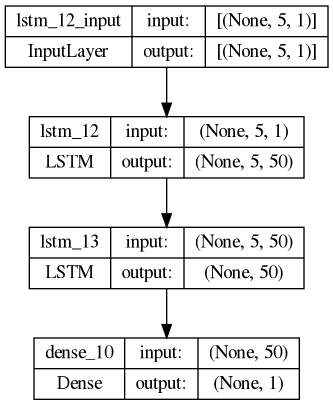

In [68]:
modelS = Sequential()
modelS.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
modelS.add(LSTM(50, activation='relu'))
modelS.add(Dense(n_features)) 
modelS.compile(optimizer='adam',
              loss='mse',
              metrics   = ['mae'] )

from tensorflow.keras.utils import plot_model
plot_model(modelS, show_shapes=True, show_layer_names=True)



Epoch 1/300
1/1 [==============================] - 4s 4s/step - loss: 13034.7568 - mae: 108.1491 - val_loss: 36092.5391 - val_mae: 189.6082
Epoch 2/300
1/1 [==============================] - 0s 51ms/step - loss: 12574.3164 - mae: 106.3716 - val_loss: 34564.9609 - val_mae: 185.5658
Epoch 3/300
1/1 [==============================] - 0s 42ms/step - loss: 12217.5127 - mae: 104.9755 - val_loss: 33099.0625 - val_mae: 181.6037
Epoch 4/300
1/1 [==============================] - 0s 36ms/step - loss: 11894.6689 - mae: 103.6897 - val_loss: 32006.8633 - val_mae: 178.5917
Epoch 5/300
1/1 [==============================] - 0s 29ms/step - loss: 11614.5869 - mae: 102.5440 - val_loss: 31195.3066 - val_mae: 176.3168
Epoch 6/300
1/1 [==============================] - 0s 29ms/step - loss: 11373.5732 - mae: 101.5297 - val_loss: 30485.2109 - val_mae: 174.3009
Epoch 7/300
1/1 [==============================] - 0s 28ms/step - loss: 11150.6260 - mae: 100.5719 - val_loss: 29870.1992 - val_mae: 172.5344
Epoch 8/

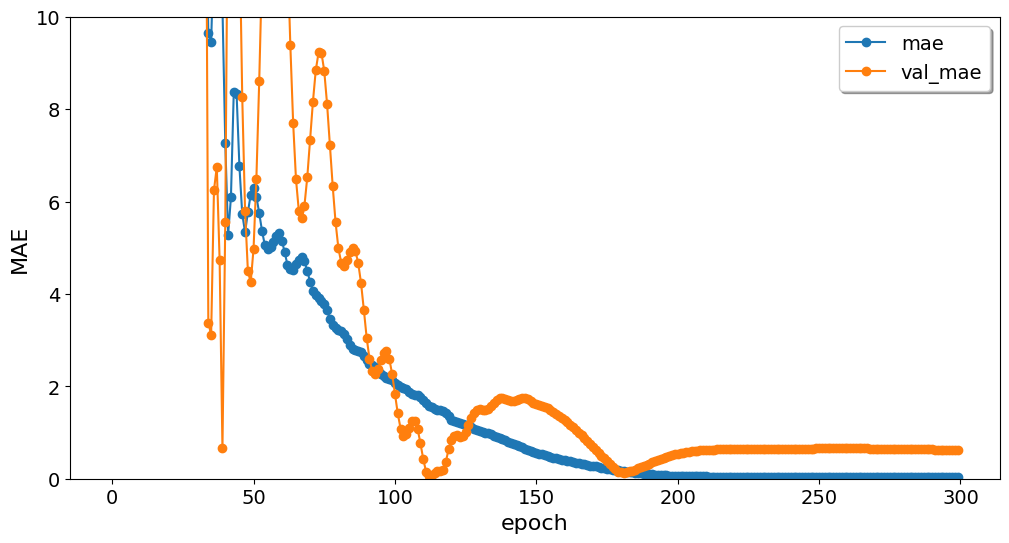

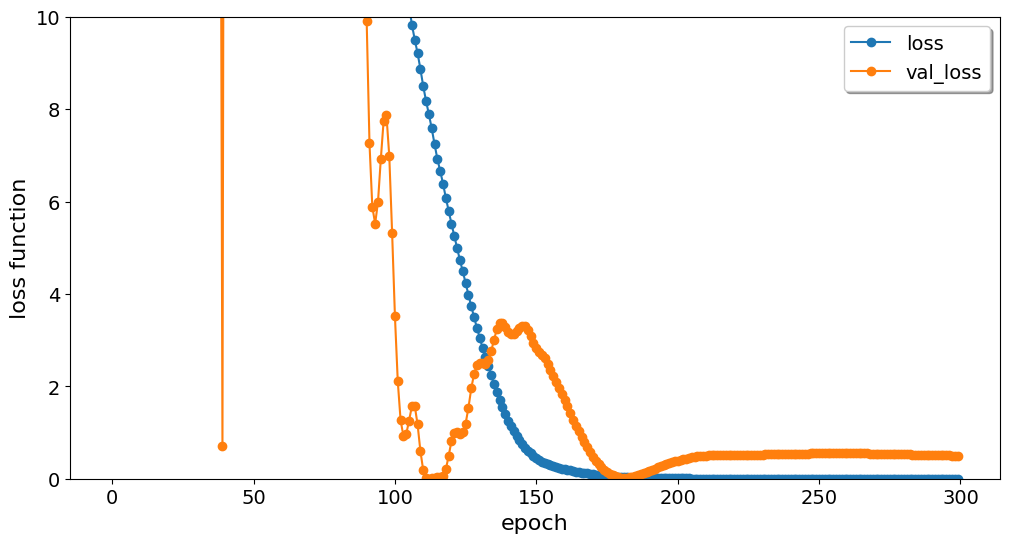

In [69]:
# fit model
epochs = 300
historyS = modelS.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_test,y_test))

plotHistory(historyS,["mae","val_mae"],"MAE",10)
plotHistory(historyS,["loss","val_loss"],"loss function",10)

MSE = predictions(raw_sequence, modelS, n_steps, n_features)
print(f"MSE = {MSE}")

### Bidirectional LSTM

<div class="intro">

On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.
</div>

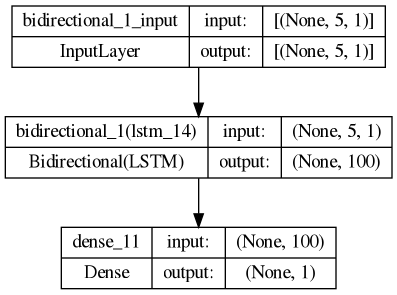

In [70]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

modelB = Sequential()
modelB.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
modelB.add(Dense(n_features)) 
modelB.compile(optimizer='adam',
              loss='mse',
              metrics   = ['mae'] )

from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True, show_layer_names=True)


Epoch 1/300
1/1 [==============================] - 0s 55ms/step - loss: 0.0038 - mae: 0.0479 - val_loss: 15.1399 - val_mae: 3.2568
Epoch 2/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0037 - mae: 0.0477 - val_loss: 15.1425 - val_mae: 3.2572
Epoch 3/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0037 - mae: 0.0476 - val_loss: 15.1451 - val_mae: 3.2576
Epoch 4/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0036 - mae: 0.0474 - val_loss: 15.1476 - val_mae: 3.2581
Epoch 5/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0036 - mae: 0.0472 - val_loss: 15.1501 - val_mae: 3.2585
Epoch 6/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0036 - mae: 0.0471 - val_loss: 15.1526 - val_mae: 3.2589
Epoch 7/300
1/1 [==============================] - 0s 44ms/step - loss: 0.0035 - mae: 0.0469 - val_loss: 15.1549 - val_mae: 3.2593
Epoch 8/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0035 - ma

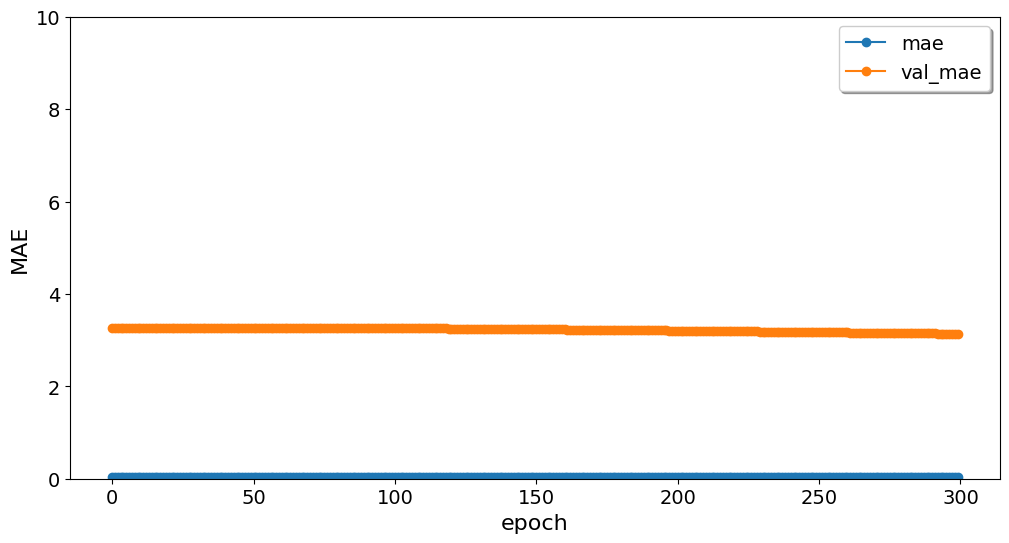

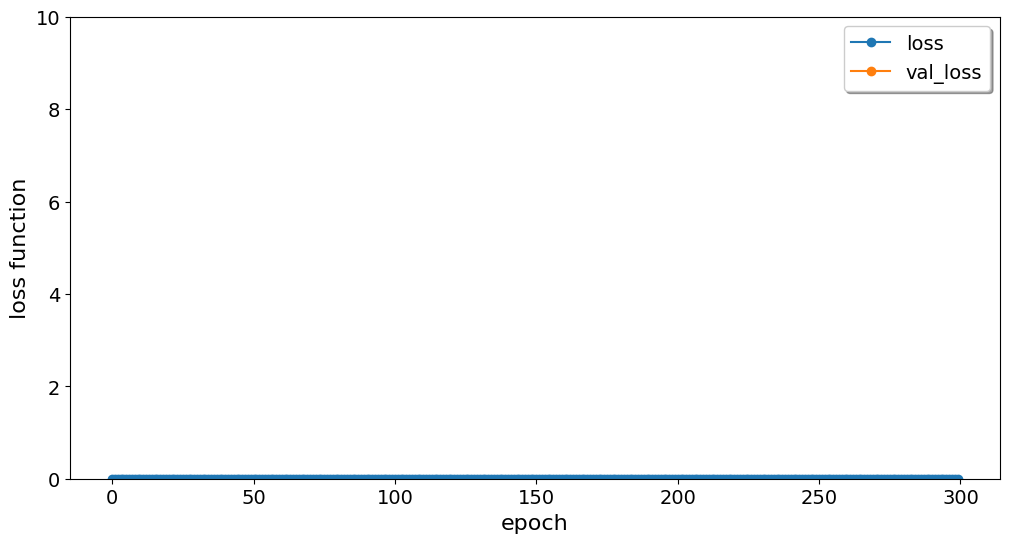

In [72]:
# fit model
epochs = 300
historyB = modelB.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_test,y_test))

plotHistory(historyB,["mae","val_mae"],"MAE",10)
plotHistory(historyB,["loss","val_loss"],"loss function",10)

MSE = predictions(raw_sequence, modelB, n_steps, n_features)
print(f"MSE = {MSE}")

### CNN LSTM

<div class="intro">

A 2D convolutional neural network, or CNN for short, is a type of neural network developed for working with two-dimensional image data.

A 1D CNN can be very effective at automatically extracting and learning features from one-dimensional sequence data such as univariate time series data.

</div>

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # because it is an univariate function
print(f"Number of time sequences = {X.shape[0]}\n"
      f"Number of time steps per sequence = {X.shape[1]}\n"
      f"Number of features to predict = {n_features}\n")
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                          input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_features))

model.compile(optimizer='adam',
              loss='mse',
              metrics   = ['mae'] )

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# fit model
epochs = 300
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_test,y_test))

plotHistory(history,["mae","val_mae"],"MAE",10)
plotHistory(history,["loss","val_loss"],"loss function",10)

MSE = predictions(raw_sequence, model, n_steps, n_features)
print(f"MSE = {MSE}")

In [46]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
t4pPC.centerTitle("after split_sequence")
print(X)
print()
print(y)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
t4pPC.centerTitle("after reshape")
print(X)
print(y)
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[10 20 30 40]
 [20 30 40 50]
 [30 40 50 60]
 [40 50 60 70]
 [50 60 70 80]]

[50 60 70 80 90]


[[[[10]
   [20]]

  [[30]
   [40]]]


 [[[20]
   [30]]

  [[40]
   [50]]]


 [[[30]
   [40]]

  [[50]
   [60]]]


 [[[40]
   [50]]

  [[60]
   [70]]]


 [[[50]
   [60]]

  [[70]
   [80]]]]
[50 60 70 80 90]


[[100.70124]]


## Prediction of a ladybug 2D trajectory via an RNN

<div style="intro">
    
**Adaptation of a fidle notebook**

<a href="https://fidle.cnrs.fr/"><img width="200" src="./ML-Figures/00-Fidle-logo-01.svg"></img></a>

<img width="200" src="./ML-Figures/Ladybug-DallE.png" style="display:block; margin-left:auto; margin-right:auto;" id="ladybug"/>

</div>

### Initialization

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

2023-10-17 16:43:51.136368: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 16:43:51.152295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 16:43:51.265410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 16:43:51.266165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 16:43:52.670153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Generation of the datasets

#### Calculation of the coordinates

<div class="intro">

The movement of the ladybird will be given by these two trigonometric relations, that depend on 8 parameters

$x_{t}=a_{x1}\sin\left[(k_{x1}+20)t\right]+a_{x2}\cos\left[(k_{x2}+10)t\right]+a_{x3}\sin\left[(k_{x3}+5)t\right]+a_{x4}\cos\left[(k_{x4}+5)t\right]$

$y_{t}=a_{y1}\cos\left[(k_{y1}+20)t\right]+a_{y2}\sin\left[(k_{y2}+10)t\right]+a_{y3}\cos\left[(k_{y3}+5)t\right]+a_{y4}\sin\left[(k_{y4}+5)t\right]$

This is a **multivariate** time series, with two values per time step.

</div>

In [6]:
def ladybug_init(s=123):
    import random
    
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):
    import numpy as np
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*np.sin(t*(kx1+20)) + ax2*np.cos(t*(kx2+10)) + ax3*np.sin(t*(kx3+5)) + ax4*np.cos(t*(kx4+5))
    y = ay1*np.cos(t*(ky1+20)) + ay2*np.sin(t*(ky2+10)) + ay3*np.cos(t*(ky3+5)) + ay4*np.sin(t*(ky4+5)) 

    return x,y

In [7]:
max_t        = 1000
delta_t      = 0.02

# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    x,y = ladybug_move(t)
    positions.append([x,y])
    
print(f"Number of coordinates = {len(positions)}")

Number of coordinates = 50000


#### Plots

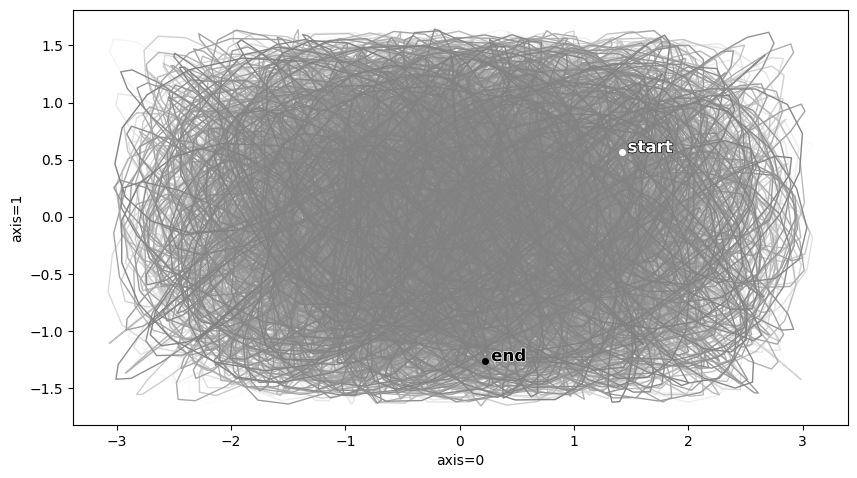

In [8]:
def traj2D(data, figsize=(10,8), monocolor=False, hide_ticks=True, lw=1, ms=4, save_as='auto'):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    """
    Plot a 2d dataset as a trajectory
    args:
        data:      Dataset to plot
        figsize:   Figure size ( (10,8))
        monocolor: Monocolor line or not. (False)
    return:
        nothing
    adapted from the fidle.scrawler.serie_2d function
    author: Jean-Luc Parouty CNRS/MIAI/SIMaP 2022
    """
    # ---- Get x,y, min and max
    #
    n     = len(data)
    k     = int(n/100)
    x,y   = data[:,0], data[:,1]
 
    # ---- Draw it
    #
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # ---- Monocolor or gray gradient
    #
    if monocolor:
        ax.plot(x,y)
    else:
        for i in range(0,100):
            a= (200-i)/200
            ax.plot(x[i*k:(i+1)*k+1], y[i*k:(i+1)*k+1], '-', color=(a,a,a),lw=lw,zorder=1)

    # ---- First point
    #
    ax.plot(x[0], y[0], 'o', color='#ffffff',markersize=ms,zorder=2)
    txt = ax.annotate('start', xy=(x[0]+0.05, y[0]), fontsize=12, color='#ffffff',weight="bold")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='#000000')])
    # ---- Last point
    #
    ax.plot(x[n-1], y[n-1], 'o', color='#000000',markersize=ms,zorder=2)
    txt = ax.annotate('end', xy=(x[n-1]+0.05, y[n-1]), fontsize=12, color='#000000',weight="bold")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='#ffffff')])
    
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('axis=0')
    ax.set_ylabel('axis=1')
    
    if hide_ticks:
        ax.set_yticks([])
        ax.set_xticks([])

    #save_fig(save_as)
    plt.show()

t4pPC.centerTitle(f"Full data set ({len(positions)} trajectory data)")
full_dataset = np.array(positions)
traj2D(full_dataset,monocolor=False,hide_ticks=False)

(50000, 2)


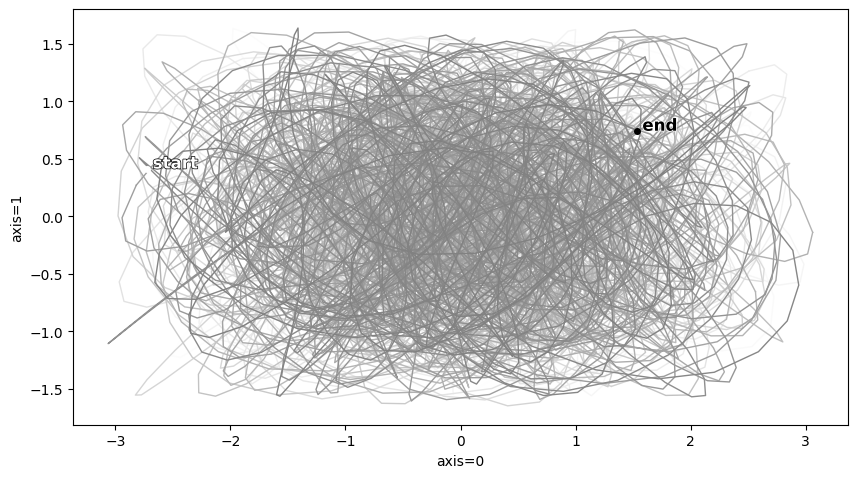

In [9]:
import random
select = 0.2 #fraction of the dataset that will be used for the ML workflow (1=all)
print(full_dataset.shape)
n = int(full_dataset.shape[0]*select)
i = random.randint(0, full_dataset.shape[0] - n)
dataset = np.array(full_dataset[i:i+n])

t4pPC.centerTitle(f"data set for ML workflow = t({i}-{i+n}) trajectory data")
traj2D(dataset,monocolor=False,hide_ticks=False)

#### Generation of the training and test sets with the hold-out method

<div class="intro">

Now let's generate the training and test sets. It's called the **hold-out** method. It involves splitting the data into multiple parts and using one part for training the model and the rest for validating and testing it.

<img width="450" src="./DS4B-svg/Basic-holdout-English.svg" style="display:block; margin-left:auto; margin-right:auto;" id="holdout"/>
</div>

mean after standard scaler = -0.00
stdd after standard scaler = 1.00


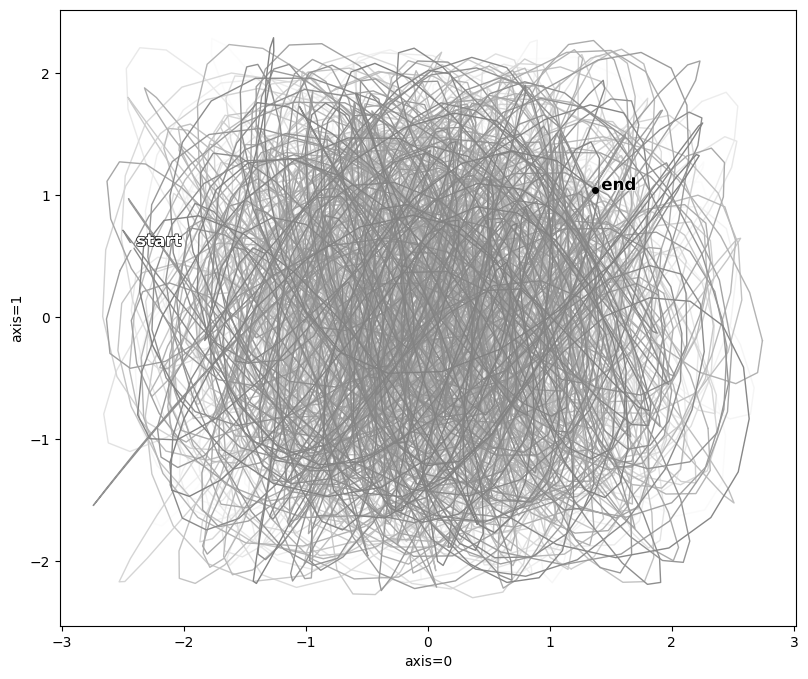

In [10]:
split_value = 0.8
ntrain = int(len(dataset)*split_value)
x_train = dataset[:ntrain]
x_test  = dataset[ntrain:]

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)
mean = x_train.mean()
stdd = x_train.std()
print(f"mean after standard scaler = {mean:.2f}")
print(f"stdd after standard scaler = {stdd:.2f}")

dataset_scaled = np.concatenate((x_train,x_test))
t4pPC.centerTitle(f"data set for ML workflow = t({i}-{i+n}) trajectory data after scaling")
traj2D(dataset_scaled,monocolor=False,hide_ticks=False)

### RNN model

#### A word about time sequences

<div class='intro'>

LSTM or GRU recurrent neural networks are capable of learning and remembering over long sequences of inputs. Using a long sequence data as-is without change may result in the problem of very long training times.
More troubling, attempting to back-propagate across very long input sequences may result in vanishing gradients, and in turn, an unlearnable model. A reasonable limit of **250-500 time steps** is often used in practice with large LSTM models.

Two key variables will be used:

`sequence_len` = number of times steps used for predicting the value of the `sequence_len + 1` time step

`predict_len` = prediction length = number of times steps **after a time sequence**

</div>

<div class="intro">

Let's first write a function that will plot `sequence_len`time steps used for prediction, followed by `predict_len` predicted time steps
</div>

In [42]:
def traj2D_real_vs_pred(sequence_real, sequence_pred, pos, figsize=(10,8), ms=6, lw=1, hide_ticks=True, save_as='auto'):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    from sklearn.metrics import mean_squared_error as MSE
    """
    Plot a 2d segment real and predicted
    args:
        sequence_real: Real sequence (length: nreal+npred)
        sequence_pred: Predicted sequence (length: npred)
        pos:           Actual first time position of the real sequence
        figsize:       Figure size (default: (10,8) )
        ms:            Marker size (default: 6)
        lw:            Line width (default: 1)
        hide_ticks:    Do not show x and y ticks if False (default: True)
    return:
        MSE between predicted position and actual position
    adapted from the fidle.scrawler.segment_2d function
    author: Jean-Luc Parouty CNRS/MIAI/SIMaP 2022
    """

    kp = len(sequence_pred)
    kr = len(sequence_real) - kp
    
    x,y = sequence_real[:,0],sequence_real[:,1]
    u,v = sequence_pred[:,0],sequence_pred[:,1]

    print(f"Length of the real sequence      = {len(sequence_real)} = {kr} + {kp} (predicted part)")
    print(f"Length of the predicted sequence = {len(sequence_pred)}")
    
    fig = plt.figure(figsize=figsize)

    ax = plt.axes()
    
    # ---- Draw real sequence without prediction
    #
    ax.plot(x[:kr], y[:kr],   'o', color='C0', fillstyle='full', zorder=2, ms=ms)
    ax.plot(x[:kr], y[:kr],   '-', color='C0', lw=lw, zorder=1)
    txt = ax.annotate(pos, xy=(x[0]+0.05, y[0]), fontsize=10, color='C0',weight="normal")
    txt = ax.annotate(pos+kr, xy=(x[kr-1]+0.05, y[kr-1]), fontsize=10, color='C0',weight="normal")
    
    # ---- What we expect
    #
    ax.plot(x[-kp:], y[-kp:], 'o', ms=ms, markeredgecolor='C0', markerfacecolor='white', zorder=2)
    ax.plot(x[-kp-1:], y[-kp-1:], '--', color='C0', lw=lw, zorder=1) #(-kp-1) to include segment between real and predicted

    # ---- What we have
    #
    ax.plot(u, v, 'o',  color='C1',fillstyle='full',zorder=2, ms=ms) #markers
    ax.plot( [x[-1-kp],u[0]], [y[-1-kp],v[0]], '--', color='C1',lw=lw, zorder=1) #segment between real and predicted results
    ax.plot(u, v, '-.', color='C1',lw=lw, zorder=1) #line
    txt = ax.annotate(pos+kr+kp, xy=(u[kp-1]+0.05, v[kp-1]), fontsize=10, color='C1',weight="normal")

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('axis=0')
    ax.set_ylabel('axis=1')
    
    if hide_ticks:
        ax.set_yticks([])
        ax.set_xticks([])

    # save_fig(save_as)
    plt.show()
    realC = [x[-kp:], y[-kp:]]
    predictedC = [u, v]
    mse = MSE(realC,predictedC)
    return mse

<div class="intro">

Let's first check its behaviour with `sequence_len` time steps, followed by `predict_len` time steps that belong to the real simulation
</div>

Length of the real sequence      = 25 = 20 + 5 (predicted part)
Length of the predicted sequence = 5


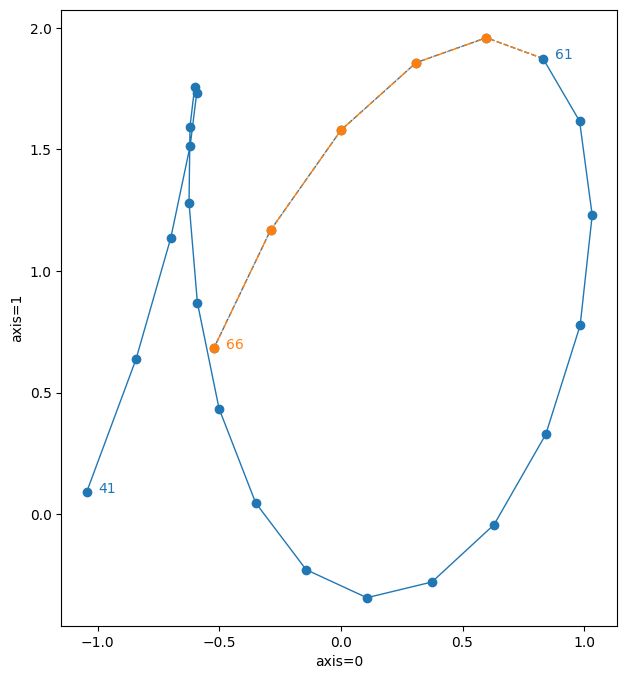

Mean Squared Error =    0.0


In [12]:
import random

sequence_len = 20
predict_len  = 5

# random selection of the beginning of the sequence
ireal = random.randint(0,len(x_test) - sequence_len - predict_len)
freal = ireal + sequence_len

mse = traj2D_real_vs_pred(x_test[ireal:freal+predict_len], x_test[freal:freal+predict_len], ireal, hide_ticks=False)
print(f"Mean Squared Error = {mse:6.4}")

<div class="rq">

The MSE is 0, as expected
</div>

#### Where to save or load the best trained model?

In [13]:
import os

dirModels = './ML-SavedModels/'
os.makedirs(dirModels,   mode=0o750, exist_ok=True)
save_path = dirModels + 'ladybug_best_model.tf'

#### Definition of the model

<div class="intro">

Let's use a GRU (see the [documentation for the GRU class of Keras](https://keras.io/api/layers/recurrent_layers/gru/))

<img width="400" src="./ML-Figures/GRUonly.svg" style="display:block; margin-left:auto; margin-right:auto;" id="GRU"/> 
</div>

In [71]:
features_len = 2 #x and y coordinates

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sequence_len, features_len)),
    keras.layers.GRU(200, return_sequences=False, activation='relu'),
    keras.layers.Dense(features_len)
])
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 200)               122400    
                                                                 
 dense_9 (Dense)             (None, 2)                 402       
                                                                 
Total params: 122802 (479.70 KB)
Trainable params: 122802 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training

#### Time series generation

In [16]:
batch_size    = 32
epochs        = 15
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

# ---- Train generator
#
train_generator = TimeseriesGenerator(x_train, x_train, stride = 1, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test, stride = 1, length=sequence_len,  batch_size=batch_size)

#### Model training

In [17]:
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, verbose=0, save_best_only=True)

In [18]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

vID.chrono_start()

history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

vID.chrono_show()

Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 0.1200 - mae: 0.2371INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 9s 32ms/step - loss: 0.1200 - mae: 0.2371 - val_loss: 0.0117 - val_mae: 0.0895
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 0.0133 - mae: 0.0917INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 8s 31ms/step - loss: 0.0133 - mae: 0.0917 - val_loss: 0.0078 - val_mae: 0.0712
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0674INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 8s 31ms/step - loss: 0.0072 - mae: 0.0674 - val_loss: 0.0068 - val_mae: 0.0681
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0528INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 27ms/step - loss: 0.0045 - mae: 0.0528 - val_loss: 0.0036 - val_mae: 0.0525
Epoch 5/15
250/250 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0449INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 8s 31ms/step - loss: 0.0033 - mae: 0.0449 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 6/15
250/250 [==============================] - 6s 24ms/step - loss: 0.0026 - mae: 0.0399 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 7/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0023 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0545
Epoch 8/15
250/250 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0353INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 27ms/step - loss: 0.0020 - mae: 0.0353 - val_loss: 9.4145e-04 - val_mae: 0.0234
Epoch 9/15
250/250 [==============================] - 6s 24ms/step - loss: 0.0017 - mae: 0.0321 - val_loss: 0.0035 - val_mae: 0.0546
Epoch 10/15
250/250 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0310INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 8s 31ms/step - loss: 0.0015 - mae: 0.0310 - val_loss: 4.7080e-04 - val_mae: 0.0173
Epoch 11/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0014 - mae: 0.0300 - val_loss: 5.3963e-04 - val_mae: 0.0178
Epoch 12/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0013 - mae: 0.0283 - val_loss: 0.0018 - val_mae: 0.0357
Epoch 13/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0012 - mae: 0.0274 - val_loss: 5.2427e-04 - val_mae: 0.0187
Epoch 14/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0011 - mae: 0.0256 - val_loss: 8.9765e-04 - val_mae: 0.0245
Epoch 15/15
250/250 [==============================] - 6s 23ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 4.9995e-04 - val_mae: 0.0167

Duration :  00:01:40 359ms


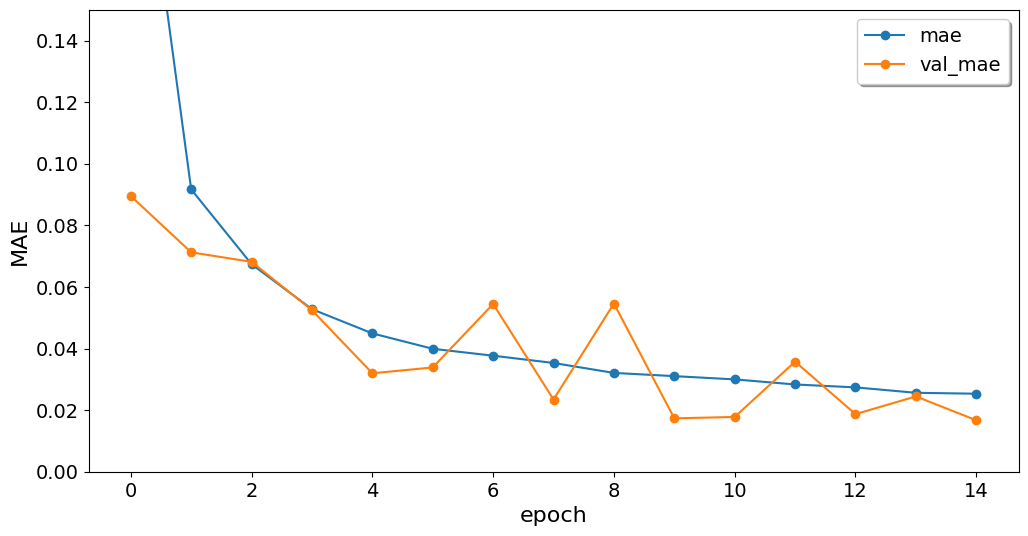

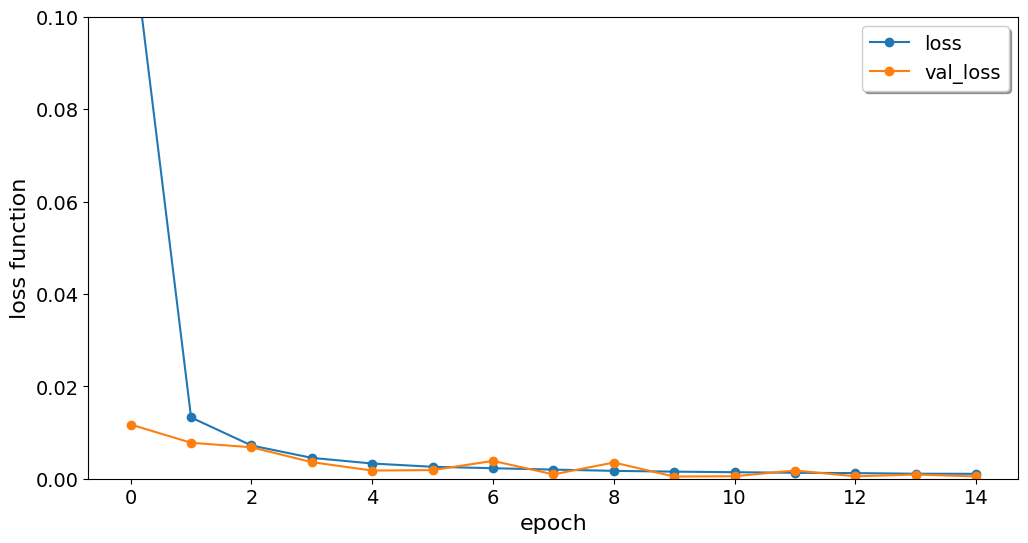

In [19]:
def plotHistory(history,prop,ylabel,ymax=0.1):
    import matplotlib.pyplot as plt
    import pandas as pd
    df=pd.DataFrame(data=history.history)
    plt.rcParams["figure.figsize"] = (12,6)
    figMAE=df.plot(y=prop,linestyle='-', marker='o',fontsize=14)
    figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
    figMAE.set_ylabel(ylabel,fontdict={'fontsize':16})
    figMAE.set_ylim([0,ymax])
    figMAE.legend(loc='upper right', shadow=True, fontsize='14')

plotHistory(history,["mae","val_mae"],"MAE",0.15)
plotHistory(history,["loss","val_loss"],"loss function",0.1)

### Prediction

#### Load the best model

In [20]:
loaded_model = tf.keras.models.load_model(save_path)
print('Best model loaded.')

Best model loaded.


#### Make a 1-step prediction on the test set

1/1 [==============================] - 0s 305ms/step
[[-0.16799124 -0.60316247]]
sequence shape      : (20, 2)
sequence true shape : (21, 2)
sequence pred shape : (1, 2)
Length of the real sequence      = 21 = 20 + 1 (predicted part)
Length of the predicted sequence = 1


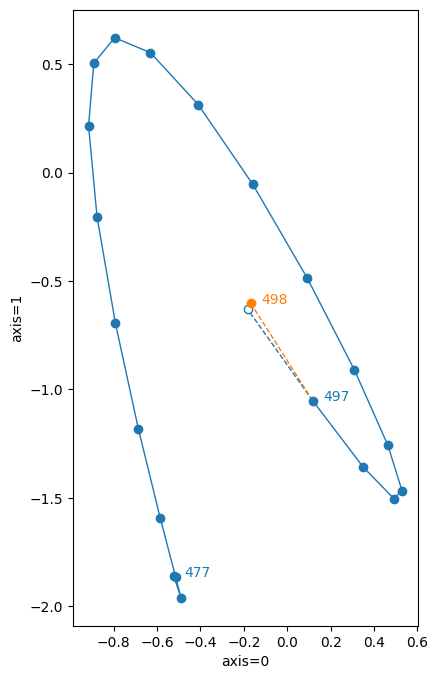

Mean Squared Error = 0.000


In [21]:
s = random.randint(0,len(x_test)-sequence_len)

predict_len = 1
sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len + predict_len]

sequence_pred = loaded_model.predict( np.array([sequence]) )
print(sequence_pred)

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

mse = traj2D_real_vs_pred(sequence_true, sequence_pred, s, hide_ticks=False)
print(f"Mean Squared Error = {mse:.3f}")

#### Make an *n*-step prediction, step by step

<div class="intro">

We need to build a function that will progressively shift the sequence window used for  prediction

<img width="700" src="./ML-Figures/RNN_unfold-timesSteps.svg" style="display:block; margin-left:auto; margin-right:auto;" id="FRNN"/>
</div>


1/1 [==============================] - 0s 19ms/step
sequence shape      : (20, 2)
sequence true shape : (25, 2)
sequence pred shape : (5, 2)
Length of the real sequence      = 25 = 20 + 5 (predicted part)
Length of the predicted sequence = 5


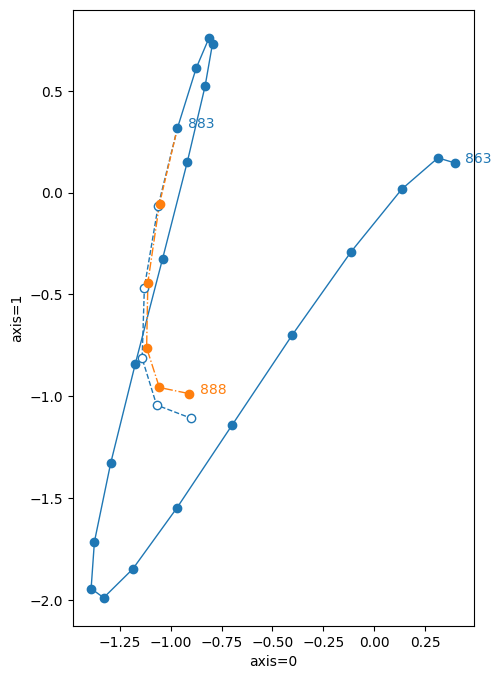

Mean Squared Error = 0.003


In [23]:
def get_nPredictions(model,sequence0,npredict=5):
    import numpy as np
    seqLen = len(sequence0)
    prediction = []
    # print(seqLen)
    # print(sequence0)
    print()
    for i in range(npredict):
        # t4pPC.centerTitle(f"iteration {i}")
        if (prediction):
            # print(sequence0)
            sequence = list(sequence0.copy()) + prediction
        else:
            sequence = list(sequence0.copy())
        # print(np.array(sequence))
        p = model.predict(np.array([sequence[-seqLen:]]))
        # print(p,'      ',p[0])
        prediction.append(p[0])
    # print()
    # print(prediction)
    return np.array(prediction)

s = random.randint(0,len(x_test)-sequence_len)

predict_len = 5
sequence0     = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len + predict_len]
sequence_pred = get_nPredictions(loaded_model,sequence0,predict_len)

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

mse = traj2D_real_vs_pred(sequence_true, sequence_pred, s, hide_ticks=False)
print(f"Mean Squared Error = {mse:.3f}")

<div class="rq">

**The error accumulates!**
</div>

### Make an *n*-step prediction, all at once

<div class="intro">

We need to train a new RNN, designed to predict all *n* next values at once
</div>

In [84]:
batch_size    = 32
epochs        = 15
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch
import os

dirModels = './ML-SavedModels/'
os.makedirs(dirModels,   mode=0o750, exist_ok=True)
save_path = dirModels + 'ladybug_best_model.tf'

sequence_len = 20
predict_len = 5

# ---- Train generator
#
train_generator = TimeseriesGenerator(x_train, x_train, stride=predict_len, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test, stride=predict_len, length=sequence_len,  batch_size=batch_size)

features_len = 2 #x and y coordinates

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sequence_len, features_len)),
    keras.layers.GRU(200, return_sequences=True, activation='relu'),
    keras.layers.Dense(features_len)
])
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 20, 200)           122400    
                                                                 
 dense_15 (Dense)            (None, 20, 2)             402       
                                                                 
Total params: 122802 (479.70 KB)
Trainable params: 122802 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [85]:
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, verbose=0, save_best_only=True)
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

vID.chrono_start()

history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

vID.chrono_show()

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'sub' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/romuald/Python3/ML/lib64/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib64/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/usr/lib64/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/usr/lib64/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10964/3758915414.py", line 8, in <module>
      history=model.fit(train_generator,
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/training.py", line 1085, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/losses.py", line 1749, in mean_absolute_error
      return backend.mean(tf.abs(y_pred - y_true), axis=-1)
Node: 'sub'
Incompatible shapes: [32,20,2] vs. [32,2]
	 [[{{node sub}}]] [Op:__inference_train_function_103514]

In [ ]:
plotHistory(history,["mae","val_mae"],"MAE",0.15)
plotHistory(history,["loss","val_loss"],"loss function",0.1)

In [37]:
loaded_model = tf.keras.models.load_model(save_path)
print('Best model loaded.')

Best model loaded.


1/1 [==============================] - 0s 36ms/step
[[-0.49863014 -1.8338054 ]]
sequence shape      : (20, 2)
sequence true shape : (25, 2)
sequence pred shape : (1, 2)
Length of the real sequence      = 25 = 24 + 1 (predicted part)
Length of the predicted sequence = 1


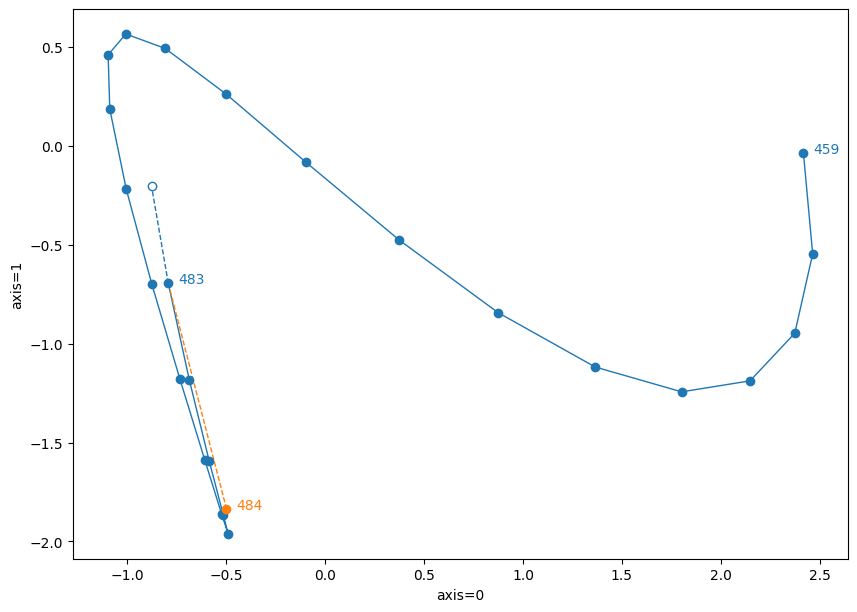

Mean Squared Error = 1.398


In [41]:
import random

sequence_len = 20
predict_len  = 5

s = random.randint(0,len(x_test)-sequence_len)

predict_len = 5
sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len + predict_len]

sequence_pred = loaded_model.predict( np.array([sequence]) )
print(sequence_pred)

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

mse = traj2D_real_vs_pred(sequence_true, sequence_pred, s, hide_ticks=False)
print(f"Mean Squared Error = {mse:.3f}")

# Useful links

[Recurrent Neural Networks by Example in Python, by *Will Koehrsen* (2018)](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)

[Wikipedia page on RNNs](https://en.wikipedia.org/wiki/Recurrent_neural_network)

[Develop LSTM Models for Time Series Forecasting](https://www.kaggle.com/code/ritesh7355/develop-lstm-models-for-time-series-forecasting)

[Hands-on machine learning with scikit-learn, keras and tensorflow (3rd edition, **2022**), Aurélien Géron, O'Reilly editions](https://github.com/ageron/handson-ml3)

Some images were generated with [DALL·E](https://openai.com/dall-e-2)

In [ ]:
t4pPC.end()